In [2]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [3]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [4]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'

def model(co2_constraint):
    network = pypsa.Network()
    hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                                '2015-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_2015.values)

    network.add("Bus",
                "electricity bus")
    # add load to the bus
    network.add("Load",
                "load",
                bus="electricity bus",
                p_set=df_elec[country].values)
    # CAPEX values for different technologies (in €/MW)
    offshoreWind_capex = 2.8e6
    onshoreWind_capex = 1.4e6
    solar_capex = 628e3
    ccgt_capex = 1.04e6
    nuclear_capex = 11.08e6

    # add the different carriers, only gas emits CO2
    network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind")
    network.add("Carrier", "solar")

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex #*(1+0.033) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_onshorewind,
                marginal_cost = 0,
                p_max_pu = CF_windOnshore.values)

    # add offshore wind generator
    df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshore.index = pd.to_datetime(df_offshore.index)
    CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex #*(1+0.033) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_offshore,
                marginal_cost = 0,
                p_max_pu = CF_windOffshore.values)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                capital_cost = capital_cost_solar,
                marginal_cost = 0,
                p_max_pu = CF_solar.values)

    # add CCGT (Combine Cycle Gas Turbine) generator
    capital_cost_CCGT = annuity(30,0.07)*ccgt_capex#*(1+0.033) # in €/MW
    fuel_cost = 30.32 # in €/MWh_th
    efficiency = 0.5 # MWh_elec/MWh_th
    marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
    network.add("Generator",
                "CCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                #p_nom_max=1000,
                capital_cost = capital_cost_CCGT,
                marginal_cost = marginal_cost_CCGT)

    # add nuclear generator
    capital_cost_nuclear = annuity(40,0.07)*nuclear_capex#*(1+0.033) # in €/MW
    fuel_cost = 6.2 # in €/MWh_th
    efficiency = 0.33 # MWh_elec/MWh_th
    marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
    network.add("Generator",
                "nuclear",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="nuclear",
                #p_nom_max=1000,
                capital_cost = capital_cost_nuclear,
                marginal_cost = marginal_cost_nuclear)
    #Create a new carrier
    network.add("Carrier",
                "H2")

    #Create a new bus
    network.add("Bus",
                "H2",
                carrier = "H2")

    #Connect the store to the bus
    network.add("Store",
          "H2 Tank",
          bus = "H2",
          e_nom_extendable = True,
          e_cyclic = True,
          capital_cost = annuity(25, 0.07)*57000*(1+0.011))

        #Add the link "H2 Electrolysis" that transport energy from the electricity bus (bus0) to the H2 bus (bus1)
        #with 80% efficiency
    network.add("Link",
          "H2 Electrolysis",
          bus0 = "electricity bus",
          bus1 = "H2",
          p_nom_extendable = True,
          efficiency = 0.8,
          capital_cost = annuity(25, 0.07)*600000*(1+0.05))

        #Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
        #with 58% efficiency
    network.add("Link",
          "H2 Fuel Cell",
          bus0 = "H2",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.58,
          capital_cost = annuity(10, 0.07)*1300000*(1+0.05))
    
    # CO2 Constraint
    network.add("GlobalConstraint",
            "co2_limit",
            type="primary_energy",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=co2_constraint)
    network.optimize(solver_name='gurobi', solver_options={"LogToConsole": 0})

    return network



In [5]:
co2_limit=1000000 #tonCO2
network = model(co2_limit)


Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 59.47it/s]
INFO:linopy.io: Writing time: 0.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-_msdtu4j.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-_msdtu4j.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 3.65e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [6]:
print(network.objective/1000000) #in 10^6 €

36545.73331986464


In [7]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    129.505161
dtype: float64


In [8]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     51011.102108
offshorewind        0.000000
solar           23597.657443
CCGT            19048.051185
nuclear         27676.544814
Name: p_nom_opt, dtype: float64

C:\Users\carlo\AppData\Local\Temp\ipykernel_33576\1530119954.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=96, freq='H')


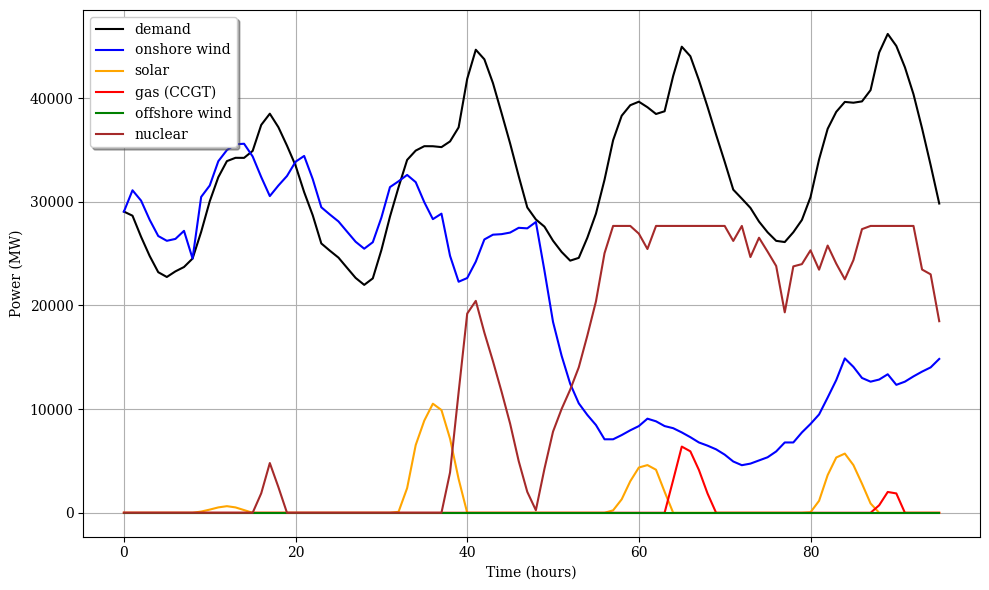

In [9]:
hours = pd.date_range(start="2015-01-01", periods=96, freq='H')
demand = network.loads_t.p['load'][0:96].values
onshore_wind = network.generators_t.p['onshorewind'][0:96].values
solar = network.generators_t.p['solar'][0:96].values    
gas_ccgt = network.generators_t.p['CCGT'][0:96].values
offshore_wind = network.generators_t.p['offshorewind'][0:96].values
nuclear = network.generators_t.p['nuclear'][0:96].values

plt.figure(figsize=(10, 6))
plt.plot(demand, color='black', label='demand')
plt.plot(onshore_wind, color='blue', label='onshore wind')
plt.plot(solar, color='orange', label='solar')
plt.plot(gas_ccgt, color='red', label='gas (CCGT)')
plt.plot(offshore_wind, color='green', label='offshore wind')
plt.plot(nuclear, color='brown', label='nuclear')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
#plt.title('Energy Production and Demand')
# plt.xticks(rotation=45)
plt.grid(True)

# Improve x-axis ticks
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(3))
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()


Text(0.5, 1.07, 'Electricity mix')

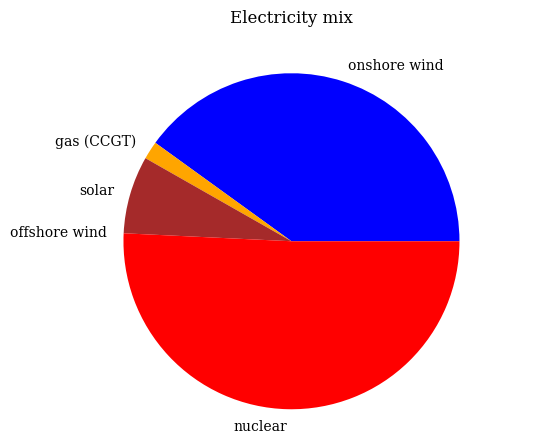

In [10]:
labels = ['onshore wind',
          'gas (CCGT)', 
          'solar',
          'offshore wind',
          'nuclear']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['offshorewind'].sum(),
         network.generators_t.p['nuclear'].sum()
]

colors=['blue', 'orange', 'brown', 'green', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

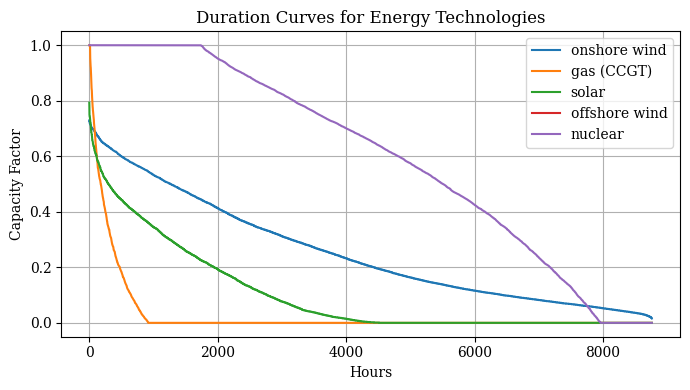

In [11]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT'],
    "solar": network.generators_t.p['solar'] / network.generators.p_nom_opt['solar'],
    "offshore wind": network.generators_t.p['offshorewind'] / network.generators.p_nom_opt['offshorewind'],
    "nuclear": network.generators_t.p['nuclear'] / network.generators.p_nom_opt['nuclear']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Define the CO2 constraint values for sensitivity analysis
co2_limits = [170e6, 140e6, 70e6, 35e6, 15e6, 5e6, 1e6, 0.5e5, 1e4, 1e3, 1e2, 0]  # in tons of CO2

results = []

# Loop through each CO2 limit
for co2_limit in co2_limits:
    # Add or update the CO2 constraint in the network
    
    # Solve the network
    network = model(co2_limit)    
    # Extract the optimized generator capacities
    results.append({
        "CO2_Limit": co2_limit,
        "Capacity_MW": network.generators.p_nom_opt
    })

# Save the results to a CSV file for further analysis
# results.to_csv("sensitivity_analysis_results.csv", index=False)

# Display the results
print(results)

Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 64.18it/s]
INFO:linopy.io: Writing time: 0.74s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ajbe_uo3.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ajbe_uo3.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 62.82it/s]
INFO:linopy.io: Writing time: 0.74s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-651vcdzs.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-651vcdzs.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 66.76it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-v3rlq00x.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-v3rlq00x.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 63.91it/s]
INFO:linopy.io: Writing time: 0.73s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-1wxrmykm.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-1wxrmykm.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 59.06it/s]
INFO:linopy.io: Writing time: 0.78s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-p0ongc_c.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-p0ongc_c.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 2.42e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 64.73it/s]
INFO:linopy.io: Writing time: 0.72s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ytxl4v1_.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-ytxl4v1_.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 3.05e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 64.85it/s]
INFO:linopy.io: Writing time: 0.75s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-0tyfxi24.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-0tyfxi24.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 3.65e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 58.14it/s]
INFO:linopy.io: Writing time: 0.76s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-wqi8kmsu.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-wqi8kmsu.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 4.38e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 67.43it/s]
INFO:linopy.io: Writing time: 0.76s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-2fl2o600.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-2fl2o600.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 4.53e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 66.19it/s]
INFO:linopy.io: Writing time: 0.78s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-n6mhp4bc.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-n6mhp4bc.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 4.60e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 57.95it/s]
INFO:linopy.io: Writing time: 0.8s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-gs2ac6n4.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-gs2ac6n4.lp


Reading time = 0.21 seconds


INFO:gurobipy:Reading time = 0.21 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 4.62e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
Index(['electricity bus'], dtype='object', name='Bus')
Index(['H2 Electrolysis'], dtype='object', name='Link')
Index(['offshorewind', 'nuclear'], dtype='object', name='Generator')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - LogToConsole: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 57.59it/s]
INFO:linopy.io: Writing time: 0.79s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-51rahhvs.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-51rahhvs.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 166449 rows, 78848 columns, 328642 nonzeros


INFO:gurobipy:obj: 166449 rows, 78848 columns, 328642 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166449 duals
Objective: 4.62e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


[{'CO2_Limit': 170000000.0, 'Capacity_MW': Generator
onshorewind     52036.876356
offshorewind        0.000000
solar               0.000000
CCGT            49825.156182
nuclear             0.000000
Name: p_nom_opt, dtype: float64}, {'CO2_Limit': 140000000.0, 'Capacity_MW': Generator
onshorewind     52036.876356
offshorewind        0.000000
solar               0.000000
CCGT            49825.156182
nuclear             0.000000
Name: p_nom_opt, dtype: float64}, {'CO2_Limit': 70000000.0, 'Capacity_MW': Generator
onshorewind     52036.876356
offshorewind        0.000000
solar               0.000000
CCGT            49825.156182
nuclear             0.000000
Name: p_nom_opt, dtype: float64}, {'CO2_Limit': 35000000.0, 'Capacity_MW': Generator
onshorewind     52036.876356
offshorewind        0.000000
solar               0.000000
CCGT            49825.156182
nuclear             0.000000
Name: p_nom_opt, dtype: float64}, {'CO2_Limit': 15000000.0, 'Capacity_MW': Generator
onshorewind     88796.3340

In [13]:
total_capacity = [entry["Capacity_MW"].sum() for entry in results]

solar = [entry["Capacity_MW"]["solar"] / total for entry, total in zip(results, total_capacity)]
onshorewind = [entry["Capacity_MW"]["onshorewind"] / total for entry, total in zip(results, total_capacity)]
ccgt = [entry["Capacity_MW"]["CCGT"] / total for entry, total in zip(results, total_capacity)]
offshorewind = [entry["Capacity_MW"]["offshorewind"] / total for entry, total in zip(results, total_capacity)]
nuclear = [entry["Capacity_MW"]["nuclear"] / total for entry, total in zip(results, total_capacity)]

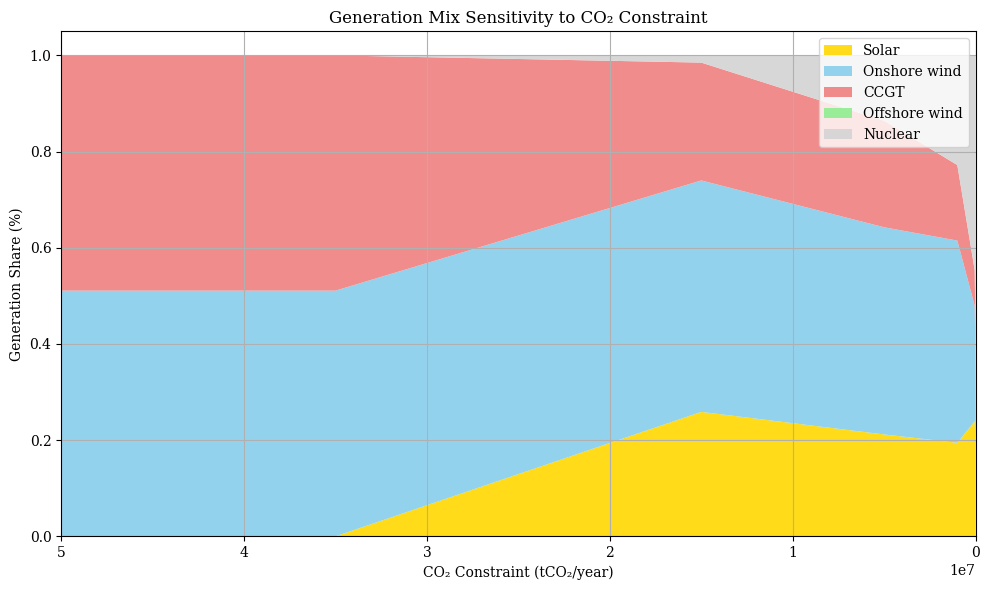

In [14]:


# Plot: Generation mix as a function of CO₂ constraint
plt.figure(figsize=(10, 6))
plt.stackplot(co2_limits, solar, onshorewind, ccgt, offshorewind, nuclear,
              labels=['Solar', 'Onshore wind', 'CCGT', 'Offshore wind', 'Nuclear'],
              colors=['gold', 'skyblue', 'lightcoral', 'lightgreen', 'lightgrey'],
              alpha=0.9)

plt.xlabel('CO₂ Constraint (tCO₂/year)')
plt.ylabel('Generation Share (%)')
plt.title('Generation Mix Sensitivity to CO₂ Constraint')
plt.xlim(0,50e6)
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()  # So tighter constraint appears on the right
plt.tight_layout()
